### Importing libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2,VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam


from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ( classification_report, confusion_matrix, accuracy_score)

import warnings
warnings.filterwarnings("ignore")

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 1: Load the dataset

In [6]:
# Dataset path
train_dir = '/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train'  
val_dir   = '/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val' 
test_dir = '/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/test'

# Class names
class_names = ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


IMG_SIZE = (124, 124)
BATCH_SIZE = 32
SEED = 22

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',  
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,   
    seed=SEED
)


print('class:', class_names)

for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)


Found 18400 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.
class: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']
Images batch shape: (32, 124, 124, 3)
Labels batch shape: (32, 8)


## Preprocess

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_process = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


Quick Visualization of Dataset

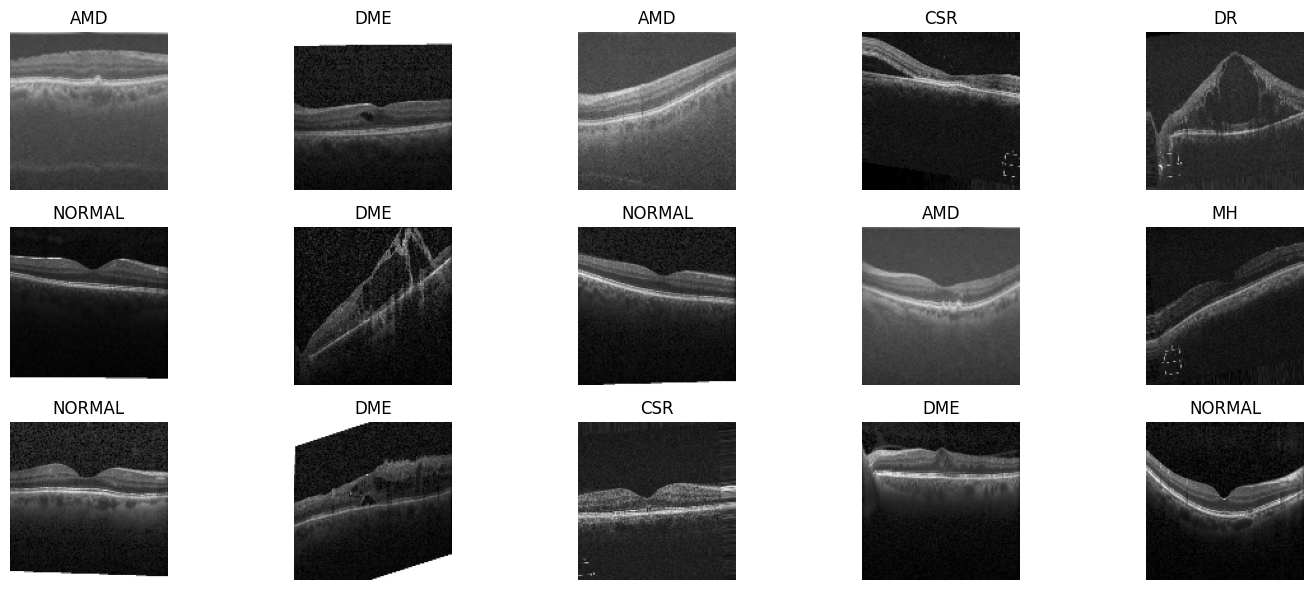

In [96]:

images, labels = next(iter(train_ds_process))

plt.figure(figsize=(15, 6))

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i].numpy())
    
    # one-hot label to class index
    class_idx = np.argmax(labels[i].numpy())
    plt.title(class_names[class_idx])
    
    plt.axis("off")

plt.tight_layout()
plt.show()



# 2: Build CNN

In [26]:
def cnn_model(input_shape=(124,124, 3), num_classes=8):
    model = models.Sequential([
        

        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),


        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),


        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),


        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation = 'relu'),

        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy', patience=10, verbose=1, mode='max',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.keras', monitor='val_accuracy',
    save_best_only=True, mode='max', verbose=1
)


my_callbacks = [early_stop, model_checkpoint]

### Model training cnn

In [27]:
base_cnn_model = cnn_model()

base_cnn_model.summary()

history = base_cnn_model.fit(
    train_ds_process,
    validation_data=val_ds,
    callbacks = my_callbacks,
    epochs=30
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 122, 122, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 122, 122, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,061,384 (7.86 MB)

 Trainable params: 2,061,192 (7.86 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4507 - loss: 1.2778
Epoch 1: val_accuracy improved from -inf to 0.69929, saving model to best_cnn_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.4511 - loss: 1.2767 - val_accuracy: 0.6993 - val_loss: 0.7330
Epoch 2/30
574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7927 - loss: 0.5275
Epoch 2: val_accuracy improved from 0.69929 to 0.83107, saving model to best_cnn_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7928 - loss: 0.5273 - val_accuracy: 0.8311 - val_loss: 0.4859
Epoch 3/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8655 - loss: 0.3730
Epoch 3: val_accuracy improved from 0.83107 to 0.89464, saving model to best_cnn_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8655 - loss: 0.3729 - val_accuracy: 0.8946 - val_loss: 0.3097
Epoch 4/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9036 - loss: 0.2793
Epoch 4: val_accura

### Accuracy and loss curves

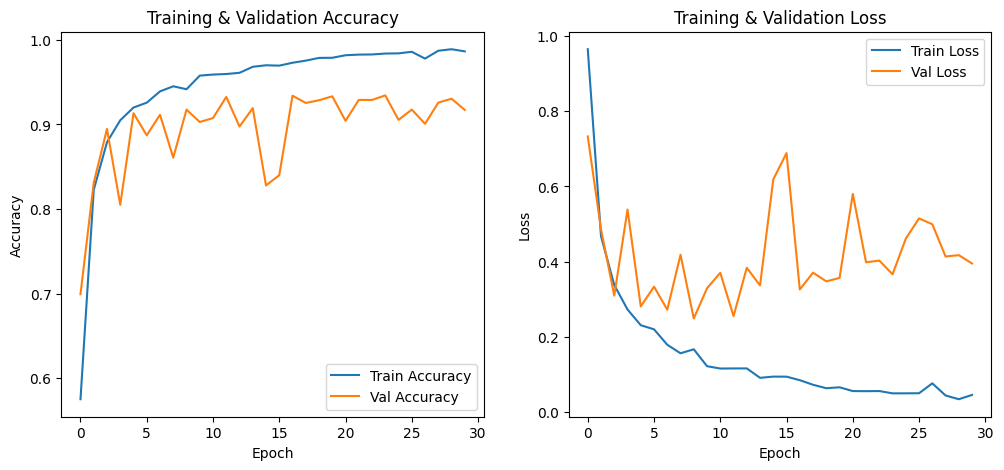

In [28]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Classification report and Confusion Matrix

88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Classification Report:

              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.91      0.85      0.88       350
         CSR       0.98      1.00      0.99       350
         DME       0.89      0.86      0.87       350
          DR       0.99      0.97      0.98       350
      DRUSEN       0.86      0.80      0.83       350
          MH       0.98      0.99      0.99       350
      NORMAL       0.80      0.93      0.86       350

    accuracy                           0.93      2800
   macro avg       0.93      0.93      0.93      2800
weighted avg       0.93      0.93      0.93      2800



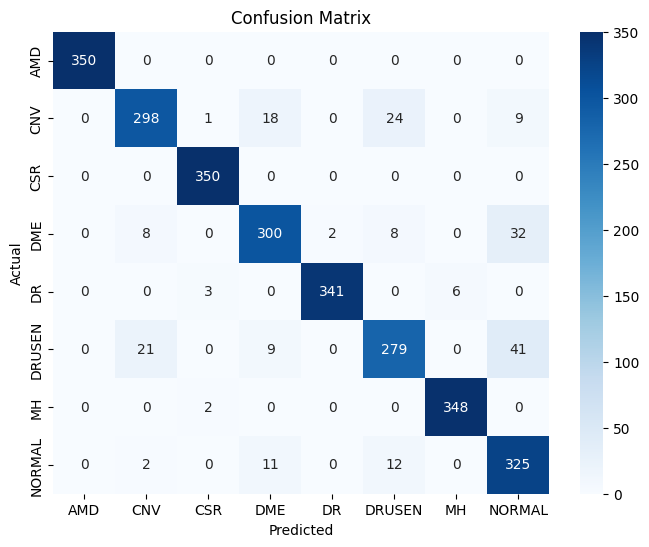

In [29]:

# one-hot labels to integers
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

# Get predictions from your model
y_pred_prob = base_cnn_model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 2.2: Augmentation

In [30]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])


def train_preprocess(image, label):
    image = data_augmentation(image) 

    image = tf.cast(image, tf.float32) / 255.0 
    return image, label

train_ds_aug = train_ds.map(train_preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

## base cnn after augmentaion


In [104]:
base_cnn_aug = cnn_model(input_shape=(124,124,3), num_classes=8)

base_cnn_aug.summary()
history_aug = base_cnn_aug.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=20
)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 122, 122, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 122, 122, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,061,384 (7.86 MB)

 Trainable params: 2,061,192 (7.86 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 47s 72ms/step - accuracy: 0.3888 - loss: 1.4098 - val_accuracy: 0.6182 - val_loss: 0.8934
Epoch 2/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.6806 - loss: 0.7892 - val_accuracy: 0.4507 - val_loss: 1.7209
Epoch 3/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.7849 - loss: 0.5563 - val_accuracy: 0.7786 - val_loss: 0.6828
Epoch 4/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.8434 - loss: 0.4205 - val_accuracy: 0.7446 - val_loss: 0.8858
Epoch 5/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.8687 - loss: 0.3736 - val_accuracy: 0.7454 - val_loss: 1.0161
Epoch 6/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.8743 - loss: 0.3441 - val_accuracy: 0.7607 - val_loss: 0.8006
Epoch 7/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.8923 - loss: 0.3023 - val_accuracy: 0.7482 - val_loss: 0.7960
Epoch 8/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.8985 - loss: 0.2838 - 

### Accuracy and loss curves comparison: Before aug vs after aug cnn 

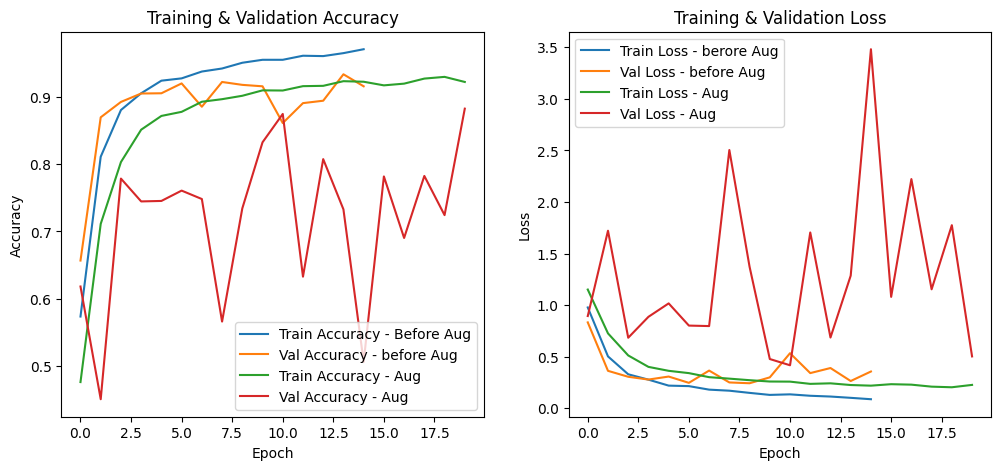

In [105]:
plt.figure(figsize=(12,5))

# Accuracy comparison
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy - Before Aug')
plt.plot(history.history['val_accuracy'], label='Val Accuracy - before Aug')
plt.plot(history_aug.history['accuracy'], label='Train Accuracy - Aug')
plt.plot(history_aug.history['val_accuracy'], label='Val Accuracy - Aug')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss comparison
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss - berore Aug')
plt.plot(history.history['val_loss'], label='Val Loss - before Aug')
plt.plot(history_aug.history['loss'], label='Train Loss - Aug')
plt.plot(history_aug.history['val_loss'], label='Val Loss - Aug')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Classification report and confusion matrix

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step
Classification Report:

              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.79      0.90      0.84       350
         CSR       0.96      0.91      0.93       350
         DME       0.81      0.79      0.80       350
          DR       0.98      0.79      0.87       350
      DRUSEN       0.85      0.85      0.85       350
          MH       0.93      0.92      0.92       350
      NORMAL       0.81      0.92      0.86       350

    accuracy                           0.88      2800
   macro avg       0.89      0.88      0.89      2800
weighted avg       0.89      0.88      0.89      2800



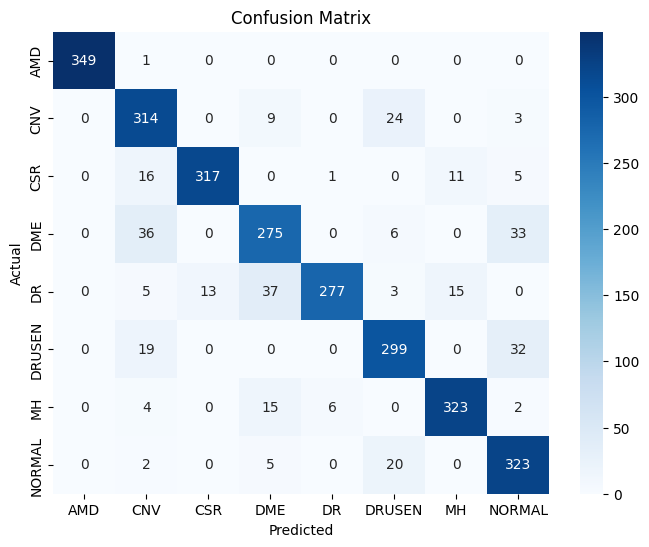

In [106]:
# # one-hot labels to integers
# y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

# Get predictions from your model
y_pred_prob = base_cnn_aug.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [29]:
# IMG_SIZE = 96
# image_size = (IMG_SIZE, IMG_SIZE)

# def preprocess_for_mobilenet(image, label):
#     # Resize
#     image = tf.image.resize(image, image_size)

#     # MobileNetV2 preprocessing (scale to [-1, 1])
#     image = preprocess_input(image)

#     return image, label


In [30]:
# train_mb = train_ds.map(preprocess_for_mobilenet)
# val_mb   = val_ds.map(preprocess_for_mobilenet)


# 3: Transfer Learning

## 3.1: VGG16

### early stoping

In [31]:


early_stop = EarlyStopping(
    monitor='val_loss', patience=7, verbose=1, mode='min',
    restore_best_weights=True
)

# model_checkpoint = ModelCheckpoint(
#     filepath='best_vgg16.keras', monitor='val_accuracy',
#     save_best_only=True, mode='max', verbose=1
# )


my_callbacks = early_stop



In [124]:
IMG_SIZE = 124
BATCH_SIZE = 32
EPOCHS = 25
NUM_CLASSES = 8

# Load pretrained VGG16 
base_model = VGG16(
    weights='imagenet',
    include_top=False,             
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model layers
base_model.trainable = False


vgg16 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
vgg16.summary()


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [125]:
history = vgg16.fit(
    train_ds_aug,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=my_callbacks
)



Epoch 1/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 53s 88ms/step - accuracy: 0.4480 - loss: 1.5285 - val_accuracy: 0.6611 - val_loss: 0.8885
Epoch 2/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.6896 - loss: 0.8626 - val_accuracy: 0.7275 - val_loss: 0.7202
Epoch 3/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.7299 - loss: 0.7290 - val_accuracy: 0.7511 - val_loss: 0.6564
Epoch 4/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.7459 - loss: 0.6805 - val_accuracy: 0.7671 - val_loss: 0.6070
Epoch 5/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.7631 - loss: 0.6353 - val_accuracy: 0.7529 - val_loss: 0.6277
Epoch 6/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.7669 - loss: 0.6157 - val_accuracy: 0.7761 - val_loss: 0.5804
Epoch 7/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.7718 - loss: 0.5975 - val_accuracy: 0.7689 - val_loss: 0.5935
Epoch 8/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.7744 - loss: 0.5881 - 

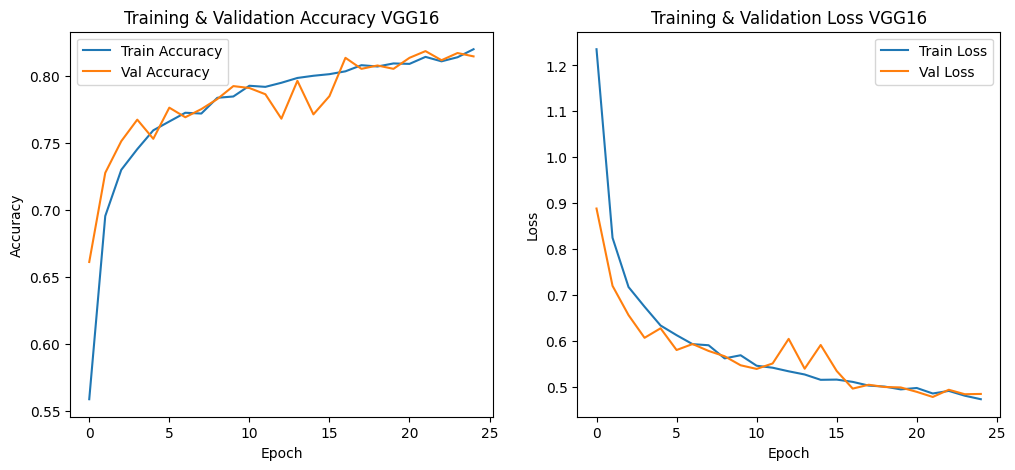

In [126]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step
Classification Report:

              precision    recall  f1-score   support

         AMD       0.99      0.96      0.98       350
         CNV       0.75      0.79      0.77       350
         CSR       0.89      0.92      0.91       350
         DME       0.72      0.59      0.65       350
          DR       0.85      0.87      0.86       350
      DRUSEN       0.59      0.71      0.65       350
          MH       0.90      0.91      0.90       350
      NORMAL       0.72      0.65      0.69       350

    accuracy                           0.80      2800
   macro avg       0.80      0.80      0.80      2800
weighted avg       0.80      0.80      0.80      2800



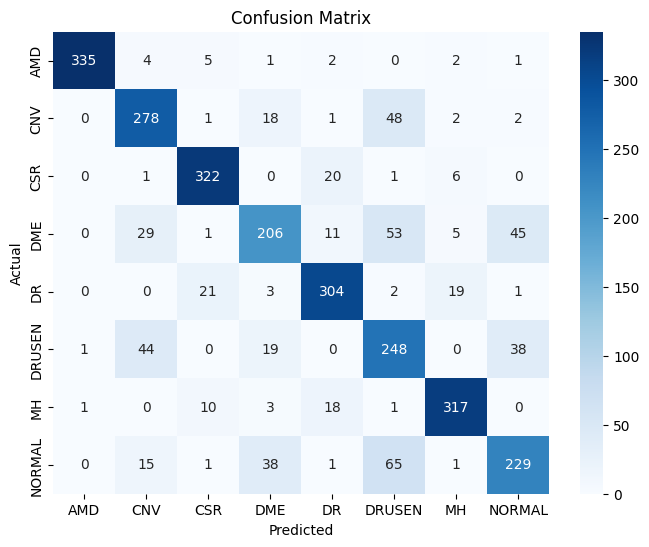

In [128]:

# # one-hot labels to integers
# y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

# Get predictions from your model
y_pred_prob = vgg16.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## 3.2 MobilenetV2

In [129]:

IMG_SIZE = 124
BATCH_SIZE = 32
EPOCHS = 25
NUM_CLASSES = 8


base_mobilenet = MobileNetV2(
    weights='imagenet',
    include_top=False,               
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)



base_mobilenet.trainable = False


mobilenet_v2 = models.Sequential([
    #layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
mobilenet_v2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
mobilenet_v2.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [130]:
history_mobilenet_v2 = mobilenet_v2.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=my_callbacks
)



Epoch 1/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - accuracy: 0.6095 - loss: 1.0496 - val_accuracy: 0.7132 - val_loss: 0.7727
Epoch 2/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.7587 - loss: 0.6187 - val_accuracy: 0.7557 - val_loss: 0.6498
Epoch 3/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.7735 - loss: 0.5775 - val_accuracy: 0.7539 - val_loss: 0.6196
Epoch 4/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.7922 - loss: 0.5380 - val_accuracy: 0.7471 - val_loss: 0.6607
Epoch 5/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.7933 - loss: 0.5211 - val_accuracy: 0.7639 - val_loss: 0.6168
Epoch 6/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.8068 - loss: 0.5036 - val_accuracy: 0.7732 - val_loss: 0.5883
Epoch 7/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8096 - loss: 0.4891 - val_accuracy: 0.7621 - val_loss: 0.6084
Epoch 8/25
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.8188 - loss: 0.4736 - 

In [132]:
loss, accuracy = mobilenet_v2.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8514 - loss: 0.3842
Test Loss: 0.5106
Test Accuracy: 0.7968


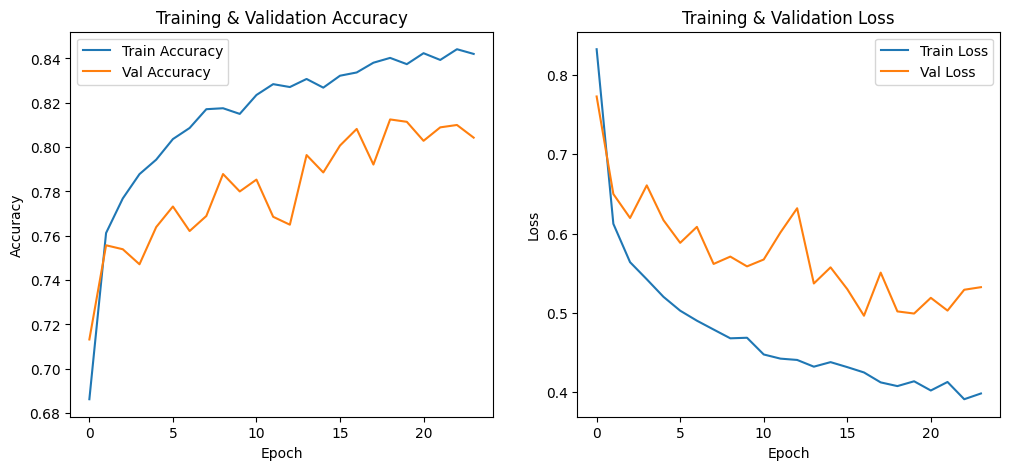

In [133]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet_v2.history['loss'], label='Train Loss')
plt.plot(history_mobilenet_v2.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
Classification Report:

              precision    recall  f1-score   support

         AMD       0.97      0.99      0.98       350
         CNV       0.80      0.73      0.76       350
         CSR       0.92      0.95      0.94       350
         DME       0.76      0.61      0.68       350
          DR       0.83      0.90      0.86       350
      DRUSEN       0.68      0.49      0.57       350
          MH       0.92      0.85      0.89       350
      NORMAL       0.57      0.86      0.69       350

    accuracy                           0.80      2800
   macro avg       0.81      0.80      0.79      2800
weighted avg       0.81      0.80      0.79      2800



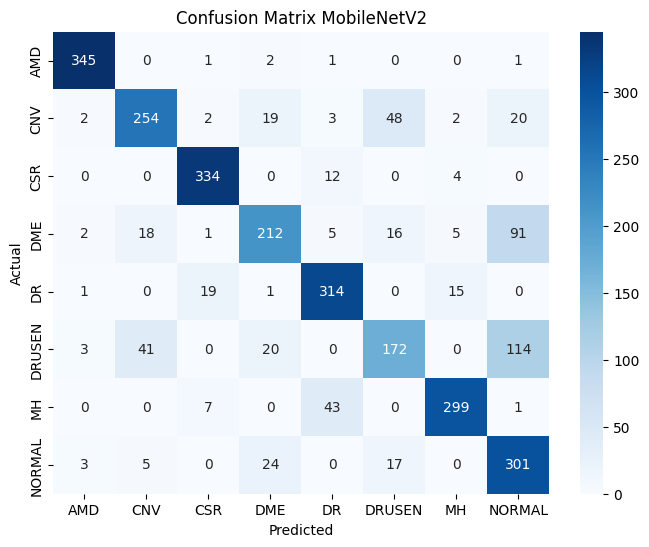

In [135]:

# one-hot labels to integers
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

# Get predictions from your model
y_pred_prob = mobilenet_v2.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix MobileNetV2')
plt.show()


# 4: Fine-tuning Last Layers

In [139]:
base_mobilenet.trainable = True


fine_tune_from = len(base_mobilenet.layers) - 30

for i, layer in enumerate(base_mobilenet.layers):
    if i < fine_tune_from:
        layer.trainable = False
    else:
        layer.trainable = True

print("Total layers in base model:", len(base_mobilenet.layers))
print("Fine-tuning from layer index:", fine_tune_from)


Total layers in base model: 154
Fine-tuning from layer index: 124


In [140]:

fine_tune_lr = 1e-5  

mobilenet_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

epochs = 20  
history_ft_mobilenet = mobilenet_v2.fit(
     train_ds_aug,
    validation_data= val_ds,
    epochs=epochs,
    batch_size=32,
    verbose=1
)



Epoch 1/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 60s 81ms/step - accuracy: 0.6077 - loss: 1.1507 - val_accuracy: 0.7771 - val_loss: 0.5697
Epoch 2/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.7378 - loss: 0.6833 - val_accuracy: 0.7757 - val_loss: 0.5663
Epoch 3/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.7762 - loss: 0.5822 - val_accuracy: 0.7979 - val_loss: 0.5108
Epoch 4/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.7969 - loss: 0.5190 - val_accuracy: 0.8111 - val_loss: 0.4915
Epoch 5/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8083 - loss: 0.4884 - val_accuracy: 0.8164 - val_loss: 0.4738
Epoch 6/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8271 - loss: 0.4512 - val_accuracy: 0.8204 - val_loss: 0.4658
Epoch 7/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.8354 - loss: 0.4268 - val_accuracy: 0.8329 - val_loss: 0.4428
Epoch 8/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8433 - loss: 0.3943 - 

*Plot Training/Validation Accuracy & Loss (Before vs After Fine-tune)*

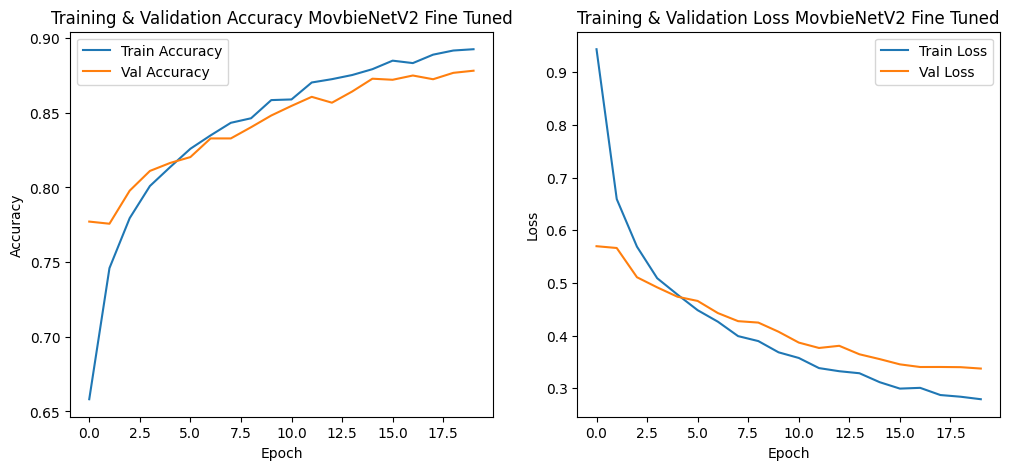

In [141]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ft_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft_mobilenet.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy MovbieNetV2 Fine Tuned')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_ft_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_ft_mobilenet.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss MovbieNetV2 Fine Tuned')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step
Classification Report:

              precision    recall  f1-score   support

         AMD       1.00      0.98      0.99       350
         CNV       0.90      0.75      0.82       350
         CSR       0.95      0.99      0.97       350
         DME       0.75      0.82      0.78       350
          DR       0.95      0.96      0.96       350
      DRUSEN       0.71      0.59      0.65       350
          MH       0.97      0.96      0.97       350
      NORMAL       0.69      0.85      0.76       350

    accuracy                           0.86      2800
   macro avg       0.87      0.86      0.86      2800
weighted avg       0.87      0.86      0.86      2800



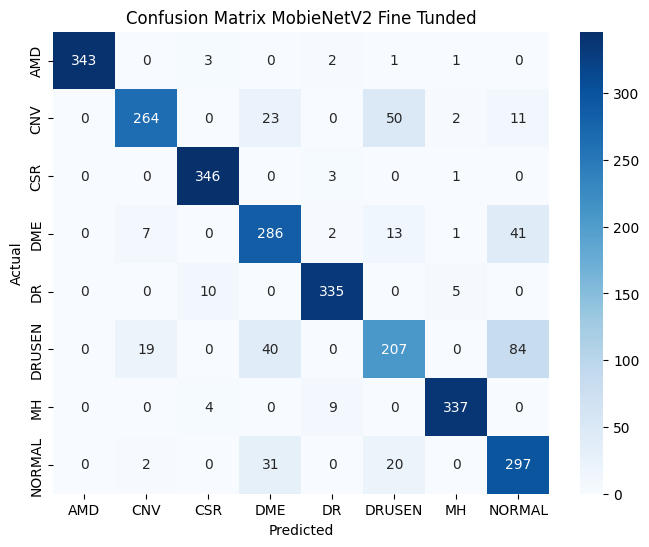

In [142]:

# one-hot labels to integers
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

# Get predictions from your model
y_pred_prob = mobilenet_v2.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix MobieNetV2 Fine Tunded')
plt.show()


# 5: Custom tf model (adding extra cnn layers)

In [32]:
base_model2 = MobileNetV2(
    include_top=False,
    weights= 'imagenet',
    input_shape=(124, 124, 3),
    pooling=None
)

base_model2.trainable = False   

# Build custom top
inputs = layers.Input(shape=(124, 124, 3))

x = base_model2(inputs)    


x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)


x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(8, activation='softmax')(x)

custom_model_mobileNetV2 = models.Model(inputs, outputs)

custom_model_mobileNetV2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

custom_model_mobileNetV2.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097,224 (15.63 MB)

 Trainable params: 1,838,472 (7.01 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [33]:

history_custom = custom_model_mobileNetV2.fit(

    train_ds_aug,
    validation_data = val_ds,
    epochs=20,
    batch_size=32,
    verbose=1
)




Epoch 1/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.6204 - loss: 0.9795 - val_accuracy: 0.7318 - val_loss: 0.6956
Epoch 2/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.7559 - loss: 0.6260 - val_accuracy: 0.7496 - val_loss: 0.6303
Epoch 3/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.7798 - loss: 0.5684 - val_accuracy: 0.7671 - val_loss: 0.6139
Epoch 4/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.7939 - loss: 0.5226 - val_accuracy: 0.7900 - val_loss: 0.5548
Epoch 5/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.8018 - loss: 0.5131 - val_accuracy: 0.7743 - val_loss: 0.5820
Epoch 6/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.8133 - loss: 0.4861 - val_accuracy: 0.7614 - val_loss: 0.6206
Epoch 7/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.8178 - loss: 0.4610 - val_accuracy: 0.7718 - val_loss: 0.5774
Epoch 8/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.8271 - loss: 0.4495 - 

In [34]:
fine_tune_from_new = len(base_model2.layers) - 30

base_model2.trainable = True
for i, layer in enumerate(base_model2.layers):
    if i < fine_tune_from_new:
        layer.trainable = False
    else:
        layer.trainable = True


custom_model_mobileNetV2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

custom_model_mobileNetV2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097,224 (15.63 MB)

 Trainable params: 3,364,872 (12.84 MB)

 Non-trainable params: 732,352 (2.79 MB)

In [35]:
history_custom_2 = custom_model_mobileNetV2.fit(
    train_ds_aug,
    validation_data  = val_ds,
    epochs=40,
    batch_size=32,
    callbacks=my_callbacks,
    verbose=1
)


Epoch 1/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.6408 - loss: 1.2311 - val_accuracy: 0.7550 - val_loss: 0.8122
Epoch 2/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.7320 - loss: 0.7711 - val_accuracy: 0.7771 - val_loss: 0.6768
Epoch 3/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.7676 - loss: 0.6313 - val_accuracy: 0.7886 - val_loss: 0.5760
Epoch 4/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.7922 - loss: 0.5578 - val_accuracy: 0.7936 - val_loss: 0.5501
Epoch 5/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8021 - loss: 0.5214 - val_accuracy: 0.8050 - val_loss: 0.5143
Epoch 6/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8163 - loss: 0.4908 - val_accuracy: 0.8186 - val_loss: 0.4759
Epoch 7/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8308 - loss: 0.4479 - val_accuracy: 0.8182 - val_loss: 0.4802
Epoch 8/40
575/575 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8334 - loss: 0.4372 - 

In [36]:
custom_model_mobileNetV2.save('custom_mobilenetv2_tuned_classifier.keras')
custom_model_mobileNetV2.save('custom_mobilenetv2_tuned_classifier.h5')

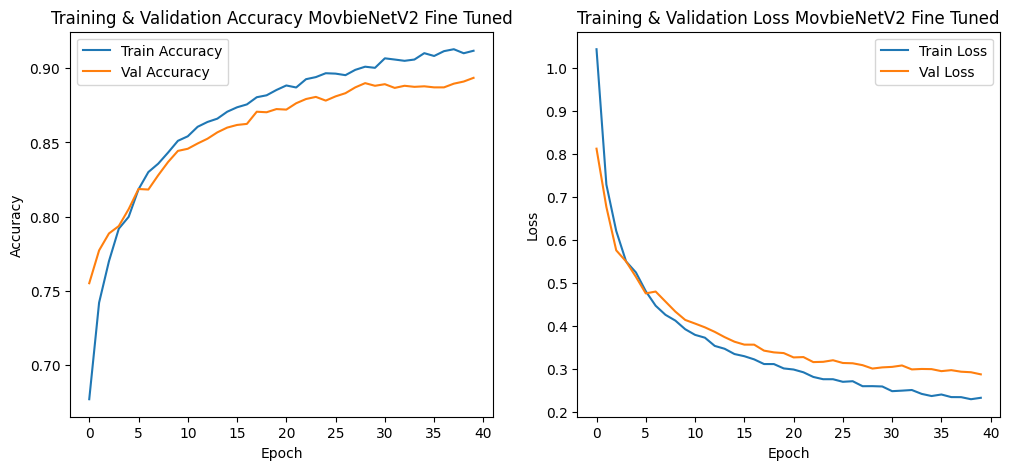

In [37]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_custom_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_custom_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy MovbieNetV2 Fine Tuned')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_custom_2.history['loss'], label='Train Loss')
plt.plot(history_custom_2.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss MovbieNetV2 Fine Tuned')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step
Classification Report:

              precision    recall  f1-score   support

         AMD       1.00      0.99      0.99       350
         CNV       0.88      0.79      0.83       350
         CSR       0.97      0.99      0.98       350
         DME       0.79      0.83      0.81       350
          DR       0.98      0.97      0.97       350
      DRUSEN       0.77      0.65      0.70       350
          MH       0.97      0.99      0.98       350
      NORMAL       0.73      0.88      0.80       350

    accuracy                           0.88      2800
   macro avg       0.89      0.88      0.88      2800
weighted avg       0.89      0.88      0.88      2800



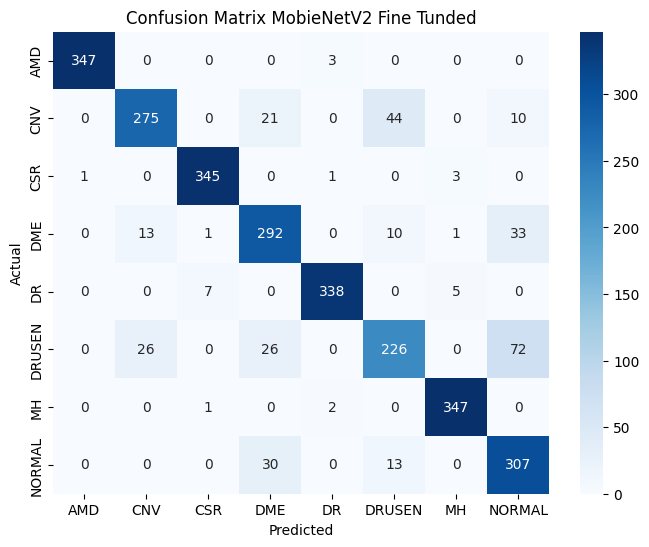

In [38]:

# one-hot labels to integers
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

# Get predictions from your model
y_pred_prob = custom_model_mobileNetV2.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix MobieNetV2 Fine Tunded')
plt.show()


# 6: CNN Visualization filter and feature map

Filters shape: (3, 3, 3, 32)


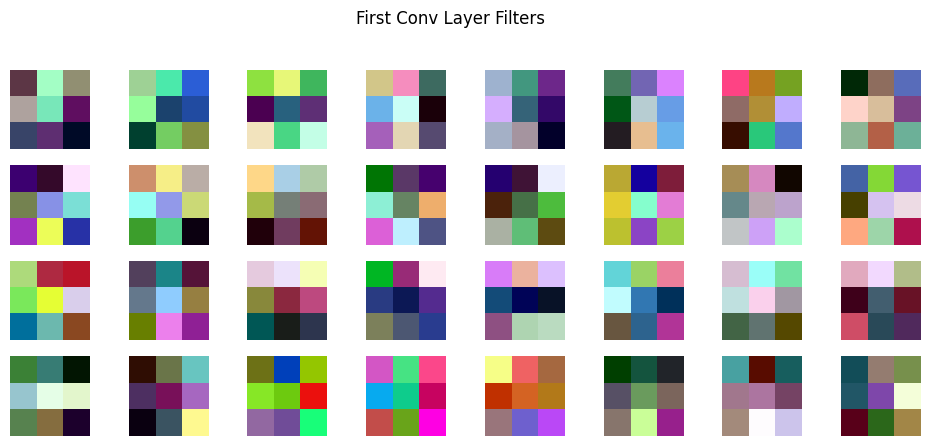

In [49]:
first_conv = None
for layer in base_cnn_model.layers:
    if isinstance(layer, layers.Conv2D):
        first_conv = layer
        break

if first_conv is None:
    print("No Conv2D layer found!")
else:
    filters, biases = first_conv.get_weights()
    print("Filters shape:", filters.shape)  

    num_filters = filters.shape[-1]
    n_cols = 8
    n_rows = num_filters // n_cols + 1

    plt.figure(figsize=(12, 6))
    for i in range(num_filters):
        f = filters[:, :, :, i]
        f_min, f_max = f.min(), f.max()
        f = (f - f_min) / (f_max - f_min + 1e-7)

        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(f)
        plt.axis('off')
    plt.suptitle("First Conv Layer Filters")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


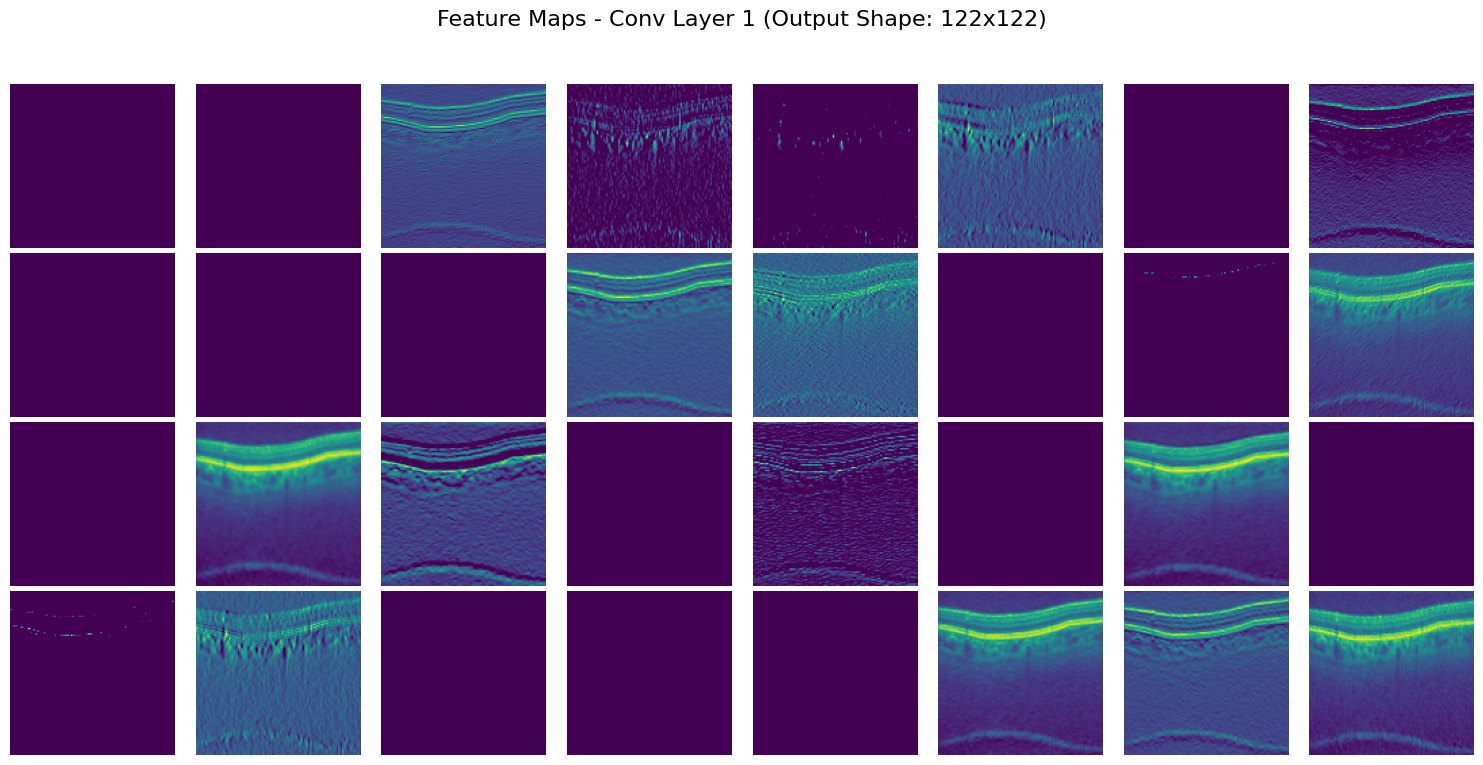

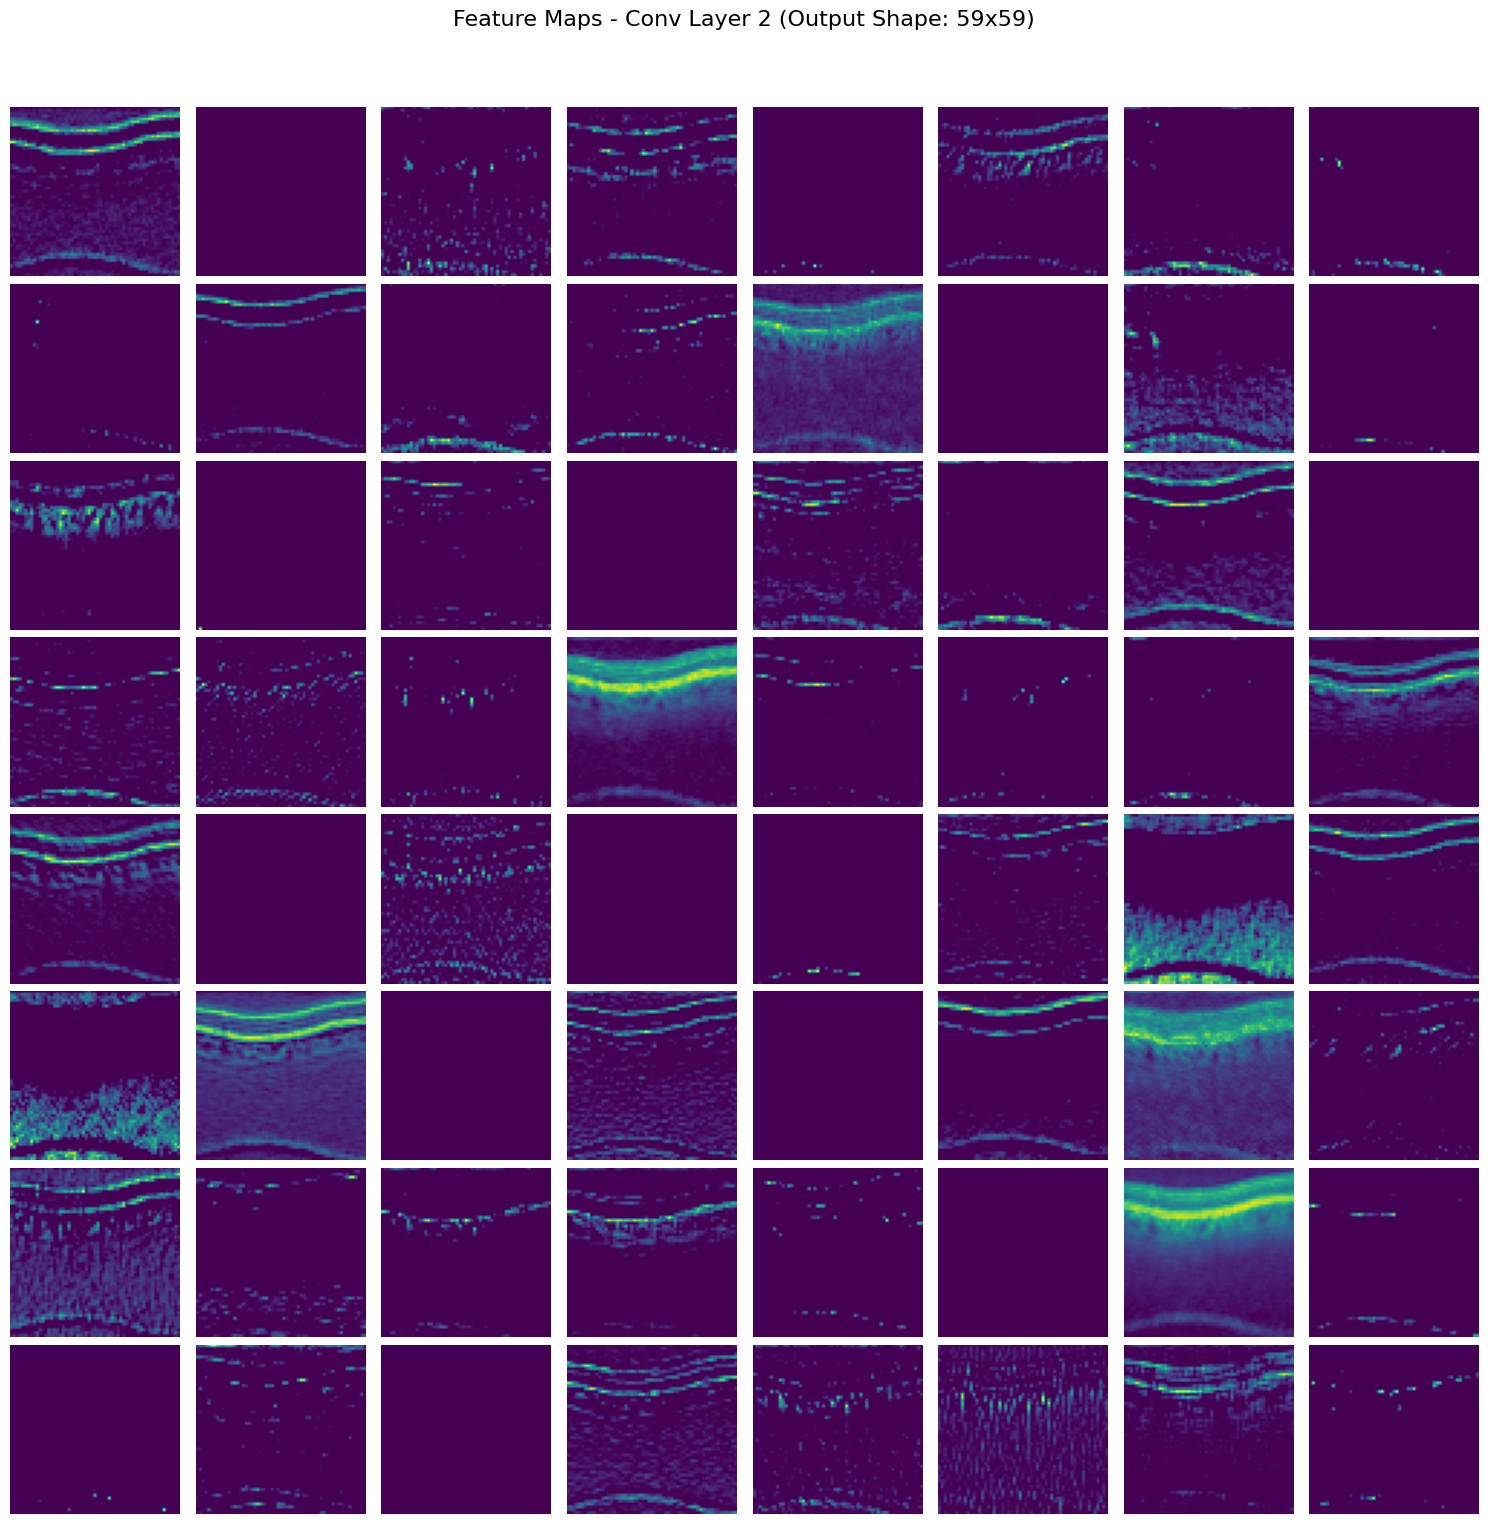

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D

input_tensor = base_cnn_model.layers[0].input 

# 2. Define the output layers
conv_layers = [layer for layer in base_cnn_model.layers if isinstance(layer, Conv2D)]
outputs = [layer.output for layer in conv_layers[:2]] 

vis_model = Model(inputs=input_tensor, outputs=outputs)


feature_maps = vis_model.predict(sample_batch)

for layer_index, fmap in enumerate(feature_maps):
    
    num_features = fmap.shape[-1]
    
    n_cols = 8
    n_rows = (num_features + n_cols - 1) // n_cols

    plt.figure(figsize=(15, n_rows * 2)) 
    
    for i in range(num_features):
        plt.subplot(n_rows, n_cols, i + 1)
        
        plt.imshow(fmap[0, :, :, i], cmap='viridis')
        plt.axis('off')
        
    plt.suptitle(f"Feature Maps - Conv Layer {layer_index+1} (Output Shape: {fmap.shape[1]}x{fmap.shape[2]})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 7: Feature Extraction from Your Simple CNN 

In [51]:
base_cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 122, 122, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 122, 122, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,183,770 (23.59 MB)

 Trainable params: 2,061,192 (7.86 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 4,122,386 (15.73 MB)

In [53]:
feature_layer_name = "dense_13"  

inputs = base_cnn_model.layers[0].input
feature_extractor = tf.keras.Model(
    inputs=inputs,
    outputs=base_cnn_model.get_layer(feature_layer_name).output
)


feature_extractor.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 122, 122, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 122, 122, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,060,352 (7.86 MB)

 Trainable params: 2,060,160 (7.86 MB)

 Non-trainable params: 192 (768.00 B)

In [54]:
# def get_labels(dataset):
#     labels = np.concatenate([y for x, y in dataset], axis=0)
#     return np.argmax(labels, axis=1)

# y_train_dense = get_labels(train_ds)
# y_test_dense = get_labels(test_ds)


# X_train_features = feature_extractor.predict(train_ds)
# X_test_features = feature_extractor.predict(test_ds)

# print("Train features shape:", X_train_features.shape)
# print("Test features shape:", X_test_features.shape)



575/575 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Train features shape: (18400, 128)
Test features shape: (2800, 128)
